<a href="https://colab.research.google.com/github/Idybaz/Human-Activity-Recognition/blob/main/HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Necessary Libraries  
This will import all the necessary libraries for data loading, preprocessing, model training, and evaluation.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

2. Set Random Seed for Reproducibility  
This ensures that the results are reproducible every time the code is ran.

In [4]:
# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)

3. Load and Explore the Data  
Here, we load the data, check for missing values, and visualize the distribution of activities in the training dataset. The countplot will visualize the classes balance.

Loading and Exploring Data

Missing Values in Train Dataset:
tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64

Missing Values in Test Dataset:
tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64

Activity Distribution in Train Dataset:
Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64


<ipython-input-5-73c5fe76d9c3>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Activity', data=train_df, palette='viridis')


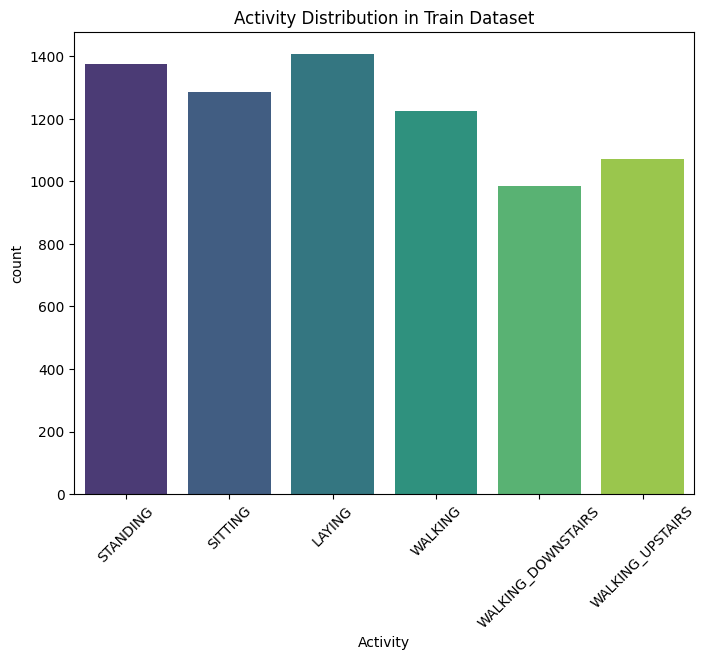

In [5]:
print("Loading and Exploring Data")

# Load train and test datasets
train_df = pd.read_csv('/content/drive/MyDrive/Downloads/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Downloads/test.csv')

# Check for missing values
print("\nMissing Values in Train Dataset:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Dataset:")
print(test_df.isnull().sum())

# Check activity distribution
print("\nActivity Distribution in Train Dataset:")
print(train_df['Activity'].value_counts())

# Visualize activity distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Activity', data=train_df, palette='viridis')
plt.title('Activity Distribution in Train Dataset')
plt.xticks(rotation=45)
plt.show()

4. Data Preprocessing (Scaling and Label Encoding)  
In this section:
The features (X_train and X_test) are separated from the target labels (y_train and y_test).
The target variable is encoded using LabelEncoder to convert categorical activity labels into numeric values.
We scale the features using StandardScaler to ensure that each feature has a mean of 0 and a standard deviation of 1.

In [6]:
print("Data Preprocessing - Scaling and Label Encoding")

# Separate features and target labels
X_train = train_df.drop(columns=['Activity'])
y_train = train_df['Activity']
X_test = test_df.drop(columns=['Activity'])
y_test = test_df['Activity']

# Encode target labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Print the label encoding mapping
print("\nLabel Encoding Mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print scaled feature statistics
print("\nScaled Train Features (First 5 Rows):")
print(X_train_scaled[:5])
print("\nScaled Test Features (First 5 Rows):")
print(X_test_scaled[:5])

Data Preprocessing - Scaling and Label Encoding

Label Encoding Mapping:
{'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}

Scaled Train Features (First 5 Rows):
[[ 0.20064157 -0.0636826  -0.41962845 ...  0.40794614 -0.00756789
  -1.8288513 ]
 [ 0.05594788  0.03148567 -0.25390836 ...  0.40911698  0.00787517
  -1.8288513 ]
 [ 0.07351535 -0.04341648 -0.07629468 ...  0.4102883   0.02650234
  -1.8288513 ]
 [ 0.06669577 -0.20842166 -0.24971245 ...  0.41465007  0.03171414
  -1.8288513 ]
 [ 0.03046897  0.02758722 -0.10984784 ...  0.42546296  0.04522502
  -1.8288513 ]]

Scaled Test Features (First 5 Rows):
[[-0.24638762 -0.13697895  1.66846245 ...  0.73357141 -0.00524394
  -1.71742488]
 [ 0.164235    0.11105901 -0.17554768 ...  0.7488403  -0.09811176
  -1.71742488]
 [ 0.01418651 -0.20474035 -0.15911067 ...  0.7446048  -0.08180304
  -1.71742488]
 [-0.05963721 -0.36557865 -0.14795978 ...  0.7581554  -0.07378381
  -1.71742488]
 [ 0.00490808 -

5. Dimensionality Reduction (PCA, KernelPCA, and LDA)  
In this section, three dimensionality reduction techniques: PCA, LDA, and KernelPCA are apllied:
PCA: Plots the cumulative explained variance to determine how many components are needed to capture the majority of the variance.
LDA: Explains the variance between classes (useful for classification).
KernelPCA: Non-linear dimensionality reduction that can capture more complex structures than PCA.

Dimensionality Reduction - PCA, KernelPCA, and LDA


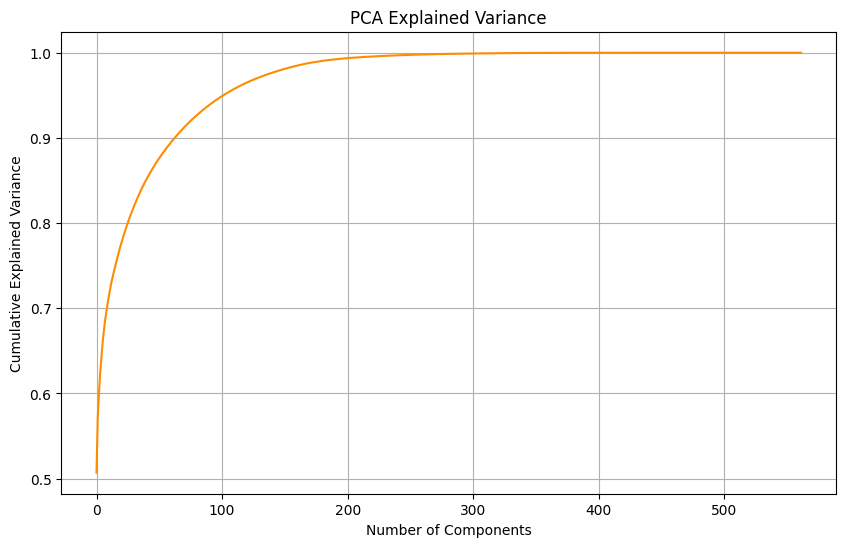

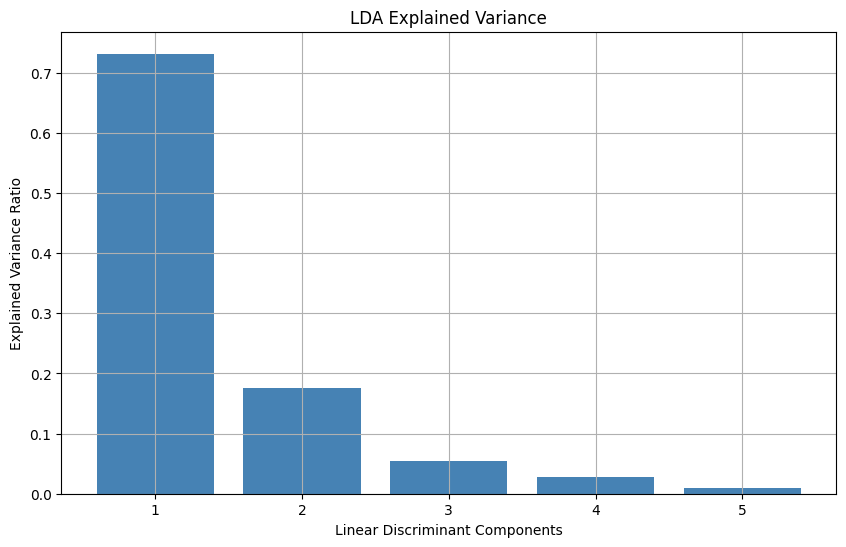

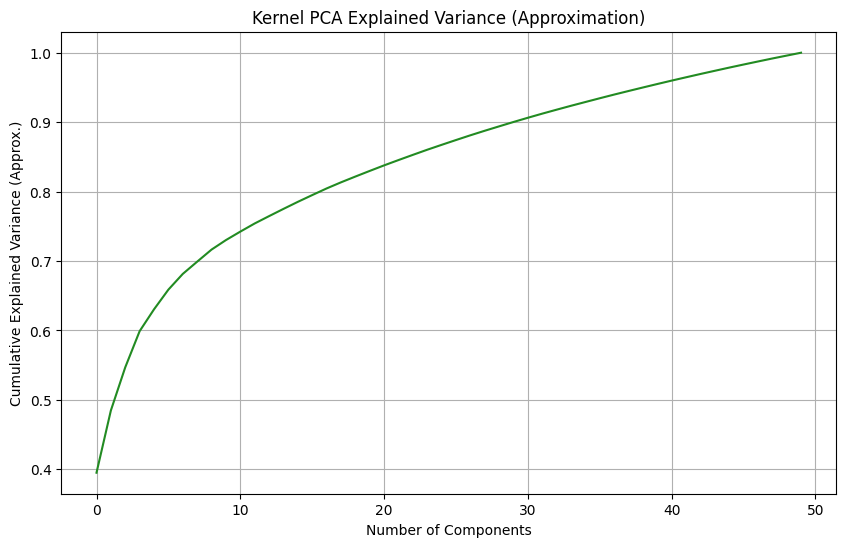

In [7]:
print("Dimensionality Reduction - PCA, KernelPCA, and LDA")

# PCA Explained Variance
pca_full = PCA().fit(X_train_scaled)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), color='darkorange')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# LDA Explained Variance (for LDA Components)
lda = LDA(n_components=None).fit(X_train_scaled, y_train_encoded)
plt.figure(figsize=(10, 6))
plt.bar(range(1, lda.explained_variance_ratio_.shape[0] + 1), lda.explained_variance_ratio_, color='steelblue')
plt.xlabel('Linear Discriminant Components')
plt.ylabel('Explained Variance Ratio')
plt.title('LDA Explained Variance')
plt.grid(True)
plt.show()

# Kernel PCA Explained Variance (Approximation)
kpca = KernelPCA(kernel='rbf', n_components=50, random_state=random_state, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(X_train_scaled)

explained_variance = np.var(X_kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), color='forestgreen')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (Approx.)')
plt.title('Kernel PCA Explained Variance (Approximation)')
plt.grid(True)
plt.show()

6. Model Training with Cross-Validation  
Pipelines are created for each model (SVM, Decision Tree, KNN, and Random Forest), including a dimensionality reduction step (PCA in this example).
Each model is trained with cross-validation (10-fold), evaluated, and the results are displayed, including accuracy, precision, recall, F1-score, and a confusion matrix.

Model Training - SVM, Decision Tree, KNN, Random Forest

Training and Evaluating SVM with PCA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.95788043 0.85597826 0.95102041 0.8462585  0.94557823 0.90612245
 0.94557823 0.96598639 0.92789116 0.95782313]
Mean Accuracy: 0.93%
Standard Deviation of Accuracy: 0.04%

SVM with PCA Performance on Test Set:
Accuracy: 94.03%
Precision: 94.11%
Recall: 94.03%
F1-Score: 94.01%

Classification Report for SVM with PCA:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       537
           1       0.93      0.88      0.91       491
           2       0.90      0.94      0.92       532
           3       0.94      0.97      0.96       496
           4       0.97      0.89      0.93       420
           5       0.90      0.95      0.93       471

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94    

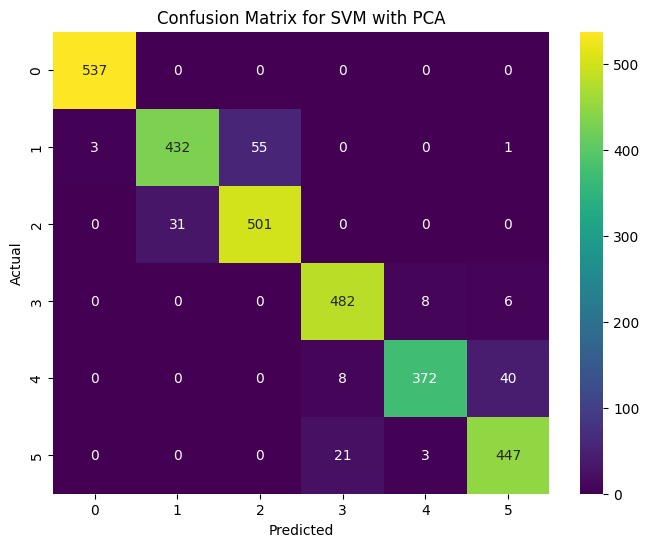


Training and Evaluating DecisionTree with PCA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.79891304 0.71603261 0.77006803 0.6952381  0.71428571 0.75782313
 0.72789116 0.76190476 0.79183673 0.81360544]
Mean Accuracy: 0.75%
Standard Deviation of Accuracy: 0.04%

DecisionTree with PCA Performance on Test Set:
Accuracy: 76.11%
Precision: 76.44%
Recall: 76.11%
F1-Score: 76.12%

Classification Report for DecisionTree with PCA:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       537
           1       0.68      0.64      0.66       491
           2       0.70      0.79      0.74       532
           3       0.76      0.81      0.78       496
           4       0.71      0.63      0.66       420
           5       0.76      0.79      0.77       471

    accuracy                           0.76      2947
   macro avg       0.76      0.76      0.76      2947
weighted avg       0.76      0.76      0.76      2947



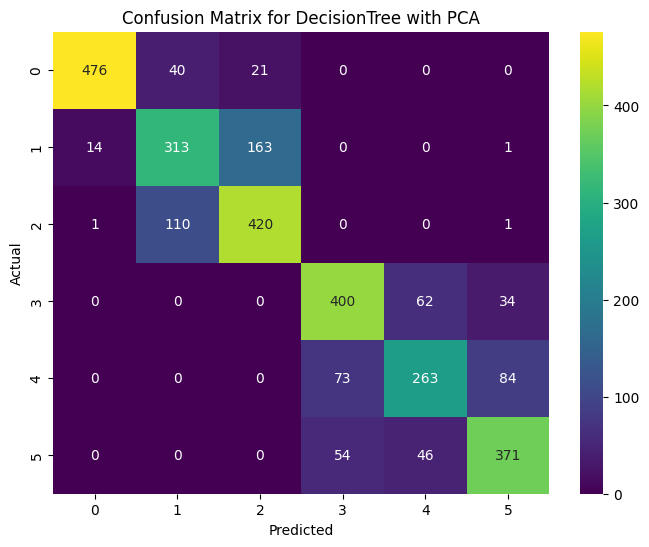


Training and Evaluating KNN with PCA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.9048913  0.80706522 0.87755102 0.85034014 0.90612245 0.85578231
 0.88435374 0.92517007 0.85986395 0.92517007]
Mean Accuracy: 0.88%
Standard Deviation of Accuracy: 0.04%

KNN with PCA Performance on Test Set:
Accuracy: 88.46%
Precision: 89.18%
Recall: 88.46%
F1-Score: 88.38%

Classification Report for KNN with PCA:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       537
           1       0.88      0.74      0.80       491
           2       0.79      0.94      0.86       532
           3       0.84      0.98      0.90       496
           4       0.95      0.78      0.86       420
           5       0.90      0.89      0.90       471

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947



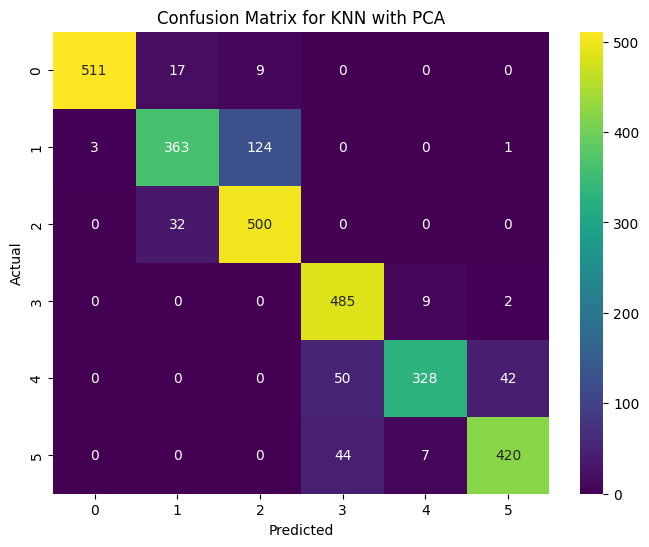


Training and Evaluating RandomForest with PCA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.91983696 0.80570652 0.89931973 0.83809524 0.91292517 0.84353741
 0.87482993 0.86666667 0.89659864 0.88571429]
Mean Accuracy: 0.87%
Standard Deviation of Accuracy: 0.03%

RandomForest with PCA Performance on Test Set:
Accuracy: 88.26%
Precision: 88.66%
Recall: 88.26%
F1-Score: 88.14%

Classification Report for RandomForest with PCA:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       537
           1       0.89      0.78      0.83       491
           2       0.82      0.95      0.88       532
           3       0.83      0.95      0.88       496
           4       0.89      0.74      0.80       420
           5       0.90      0.89      0.89       471

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947



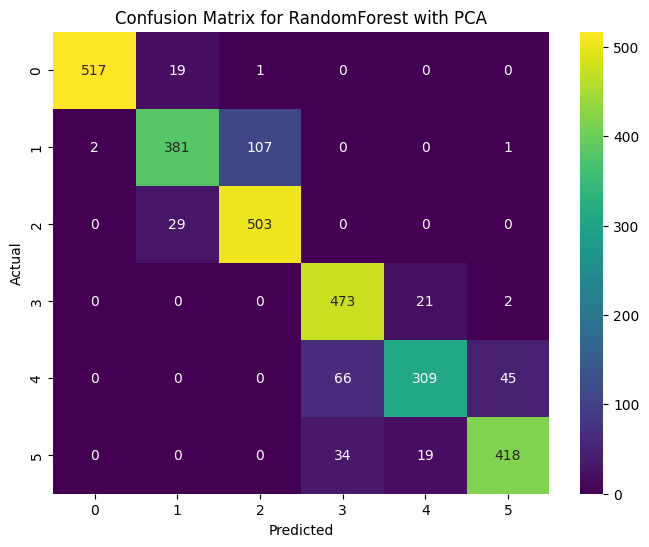


Training and Evaluating SVM with KernelPCA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.94701087 0.8111413  0.89931973 0.83129252 0.91836735 0.84897959
 0.87346939 0.91972789 0.89795918 0.96326531]
Mean Accuracy: 0.89%
Standard Deviation of Accuracy: 0.05%

SVM with KernelPCA Performance on Test Set:
Accuracy: 91.69%
Precision: 91.77%
Recall: 91.69%
F1-Score: 91.69%

Classification Report for SVM with KernelPCA:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       537
           1       0.87      0.85      0.86       491
           2       0.87      0.91      0.89       532
           3       0.92      0.95      0.93       496
           4       0.95      0.88      0.91       420
           5       0.91      0.94      0.92       471

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



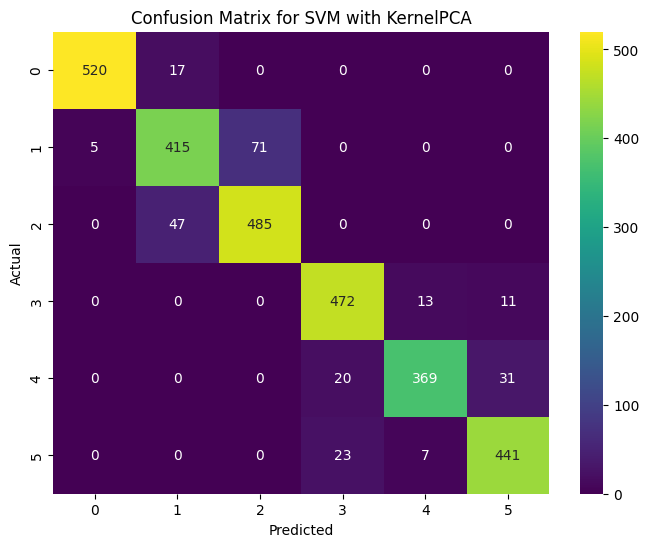


Training and Evaluating DecisionTree with KernelPCA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.83423913 0.74456522 0.76734694 0.75238095 0.76054422 0.76870748
 0.79455782 0.77823129 0.81768707 0.82585034]
Mean Accuracy: 0.78%
Standard Deviation of Accuracy: 0.03%

DecisionTree with KernelPCA Performance on Test Set:
Accuracy: 79.78%
Precision: 80.27%
Recall: 79.78%
F1-Score: 79.80%

Classification Report for DecisionTree with KernelPCA:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       537
           1       0.68      0.74      0.71       491
           2       0.77      0.77      0.77       532
           3       0.77      0.88      0.82       496
           4       0.79      0.65      0.71       420
           5       0.81      0.82      0.81       471

    accuracy                           0.80      2947
   macro avg       0.80      0.79      0.79      2947
weighted avg       0.80      0.80      0.80     

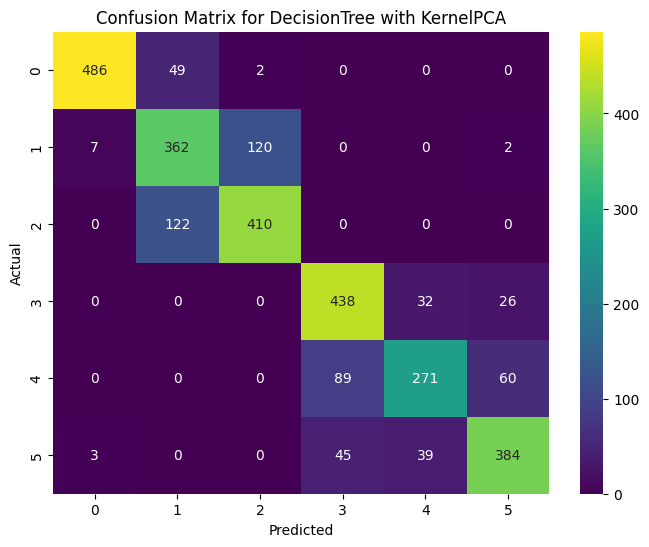


Training and Evaluating KNN with KernelPCA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.89266304 0.80298913 0.80680272 0.80408163 0.88027211 0.8
 0.80408163 0.90340136 0.85986395 0.90340136]
Mean Accuracy: 0.85%
Standard Deviation of Accuracy: 0.04%

KNN with KernelPCA Performance on Test Set:
Accuracy: 85.41%
Precision: 85.58%
Recall: 85.41%
F1-Score: 85.37%

Classification Report for KNN with KernelPCA:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       537
           1       0.79      0.73      0.76       491
           2       0.77      0.86      0.81       532
           3       0.84      0.89      0.87       496
           4       0.86      0.77      0.81       420
           5       0.87      0.90      0.89       471

    accuracy                           0.85      2947
   macro avg       0.85      0.85      0.85      2947
weighted avg       0.86      0.85      0.85      2947



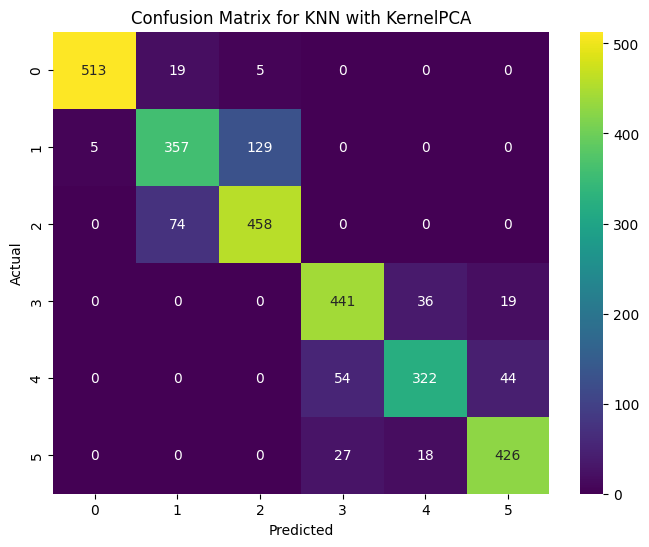


Training and Evaluating RandomForest with KernelPCA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.92119565 0.82472826 0.87482993 0.83129252 0.8952381  0.81768707
 0.84489796 0.87755102 0.89115646 0.91020408]
Mean Accuracy: 0.87%
Standard Deviation of Accuracy: 0.04%

RandomForest with KernelPCA Performance on Test Set:
Accuracy: 88.50%
Precision: 88.77%
Recall: 88.50%
F1-Score: 88.35%

Classification Report for RandomForest with KernelPCA:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       537
           1       0.85      0.80      0.82       491
           2       0.83      0.90      0.87       532
           3       0.85      0.95      0.89       496
           4       0.92      0.72      0.81       420
           5       0.89      0.96      0.92       471

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.88      0.88     

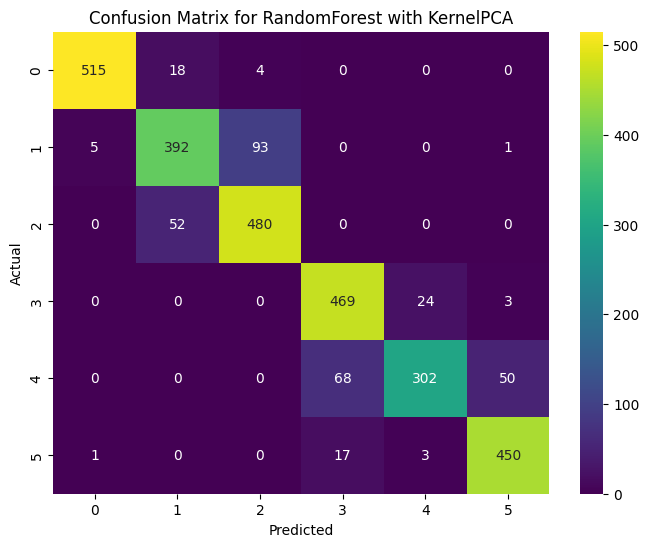


Training and Evaluating SVM with LDA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.98369565 0.8736413  0.98367347 0.89795918 0.93741497 0.97006803
 0.98503401 0.98095238 0.98231293 0.98639456]
Mean Accuracy: 0.96%
Standard Deviation of Accuracy: 0.04%

SVM with LDA Performance on Test Set:
Accuracy: 96.71%
Precision: 96.76%
Recall: 96.71%
F1-Score: 96.70%

Classification Report for SVM with LDA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.95      0.89      0.92       491
           2       0.91      0.96      0.93       532
           3       0.99      0.99      0.99       496
           4       1.00      0.98      0.99       420
           5       0.97      0.99      0.98       471

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



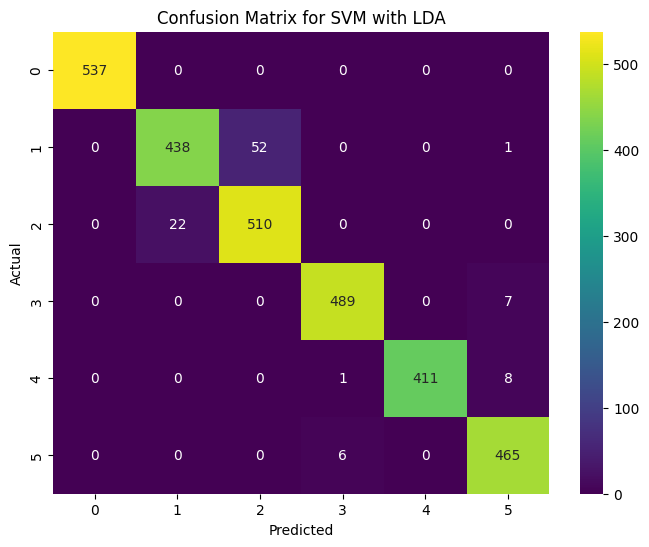


Training and Evaluating DecisionTree with LDA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.97146739 0.86141304 0.97006803 0.85034014 0.95238095 0.95918367
 0.97687075 0.97823129 0.97006803 0.9755102 ]
Mean Accuracy: 0.95%
Standard Deviation of Accuracy: 0.05%

DecisionTree with LDA Performance on Test Set:
Accuracy: 95.25%
Precision: 95.29%
Recall: 95.25%
F1-Score: 95.25%

Classification Report for DecisionTree with LDA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.91      0.89      0.90       491
           2       0.90      0.92      0.91       532
           3       0.97      0.99      0.98       496
           4       1.00      0.94      0.97       420
           5       0.94      0.97      0.95       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



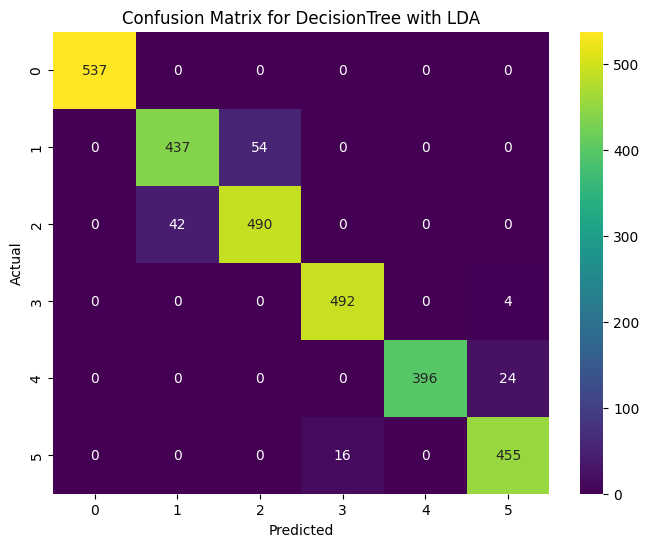


Training and Evaluating KNN with LDA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.98233696 0.87228261 0.98231293 0.91020408 0.93741497 0.96598639
 0.98367347 0.97959184 0.97823129 0.98911565]
Mean Accuracy: 0.96%
Standard Deviation of Accuracy: 0.04%

KNN with LDA Performance on Test Set:
Accuracy: 96.54%
Precision: 96.63%
Recall: 96.54%
F1-Score: 96.53%

Classification Report for KNN with LDA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.88      0.92       491
           2       0.90      0.96      0.93       532
           3       0.98      0.99      0.98       496
           4       1.00      0.98      0.99       420
           5       0.97      0.99      0.98       471

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



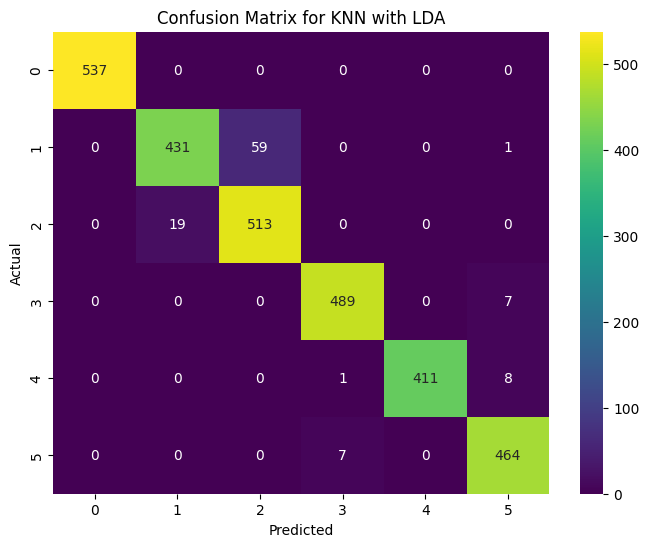


Training and Evaluating RandomForest with LDA Model with Cross-Validation
Cross-Validation Accuracy Scores: [0.98233696 0.86277174 0.98367347 0.8585034  0.95510204 0.96326531
 0.98911565 0.98367347 0.9755102  0.9877551 ]
Mean Accuracy: 0.95%
Standard Deviation of Accuracy: 0.05%

RandomForest with LDA Performance on Test Set:
Accuracy: 96.23%
Precision: 96.37%
Recall: 96.23%
F1-Score: 96.22%

Classification Report for RandomForest with LDA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.86      0.91       491
           2       0.88      0.97      0.92       532
           3       0.97      0.99      0.98       496
           4       1.00      0.98      0.99       420
           5       0.97      0.97      0.97       471

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



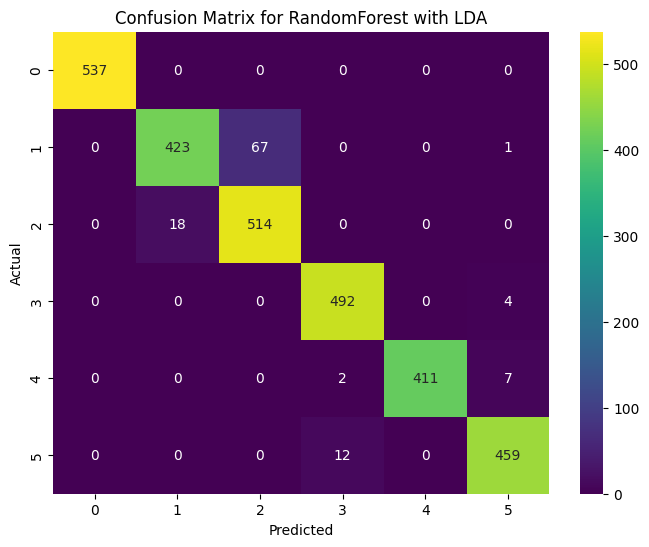

In [14]:
print("Model Training - SVM, Decision Tree, KNN, Random Forest")

# Define pipelines for each model with dimensionality reduction
pipelines = {
    'SVM with PCA': Pipeline([
        ('dim_red', PCA(n_components=120)),  # PCA for dimensionality reduction
        ('classifier', SVC(random_state=random_state))
    ]),
    'DecisionTree with PCA': Pipeline([
        ('dim_red', PCA(n_components=120)),
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ]),
    'KNN with PCA': Pipeline([
        ('dim_red', PCA(n_components=120)),
        ('classifier', KNeighborsClassifier())
    ]),
    'RandomForest with PCA': Pipeline([
        ('dim_red', PCA(n_components=120)),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ]),
    'SVM with KernelPCA': Pipeline([
        ('dim_red', KernelPCA(kernel='rbf', n_components=40, fit_inverse_transform=True)),
        ('classifier', SVC(random_state=random_state))
    ]),
    'DecisionTree with KernelPCA': Pipeline([
        ('dim_red', KernelPCA(kernel='rbf', n_components=40, fit_inverse_transform=True)),
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ]),
    'KNN with KernelPCA': Pipeline([
        ('dim_red', KernelPCA(kernel='rbf', n_components=40, fit_inverse_transform=True)),
        ('classifier', KNeighborsClassifier())
    ]),
    'RandomForest with KernelPCA': Pipeline([
        ('dim_red', KernelPCA(kernel='rbf', n_components=40, fit_inverse_transform=True)),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ]),
    'SVM with LDA': Pipeline([
        ('dim_red', LDA(n_components=5)),  # LDA for dimensionality reduction
        ('classifier', SVC(random_state=random_state))
    ]),
    'DecisionTree with LDA': Pipeline([
        ('dim_red', LDA(n_components=5)),
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ]),
    'KNN with LDA': Pipeline([
        ('dim_red', LDA(n_components=5)),
        ('classifier', KNeighborsClassifier())
    ]),
    'RandomForest with LDA': Pipeline([
        ('dim_red', LDA(n_components=5)),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])
}

# Evaluate models using cross-validation
for model_name, pipeline in pipelines.items():
    print(f"\nTraining and Evaluating {model_name} Model with Cross-Validation")

    # Perform cross-validation (e.g., 10-fold cross-validation)
    cv_scores = cross_val_score(pipeline, X_train_scaled, y_train_encoded, cv=10, scoring='accuracy')

    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.2f}%")
    print(f"Standard Deviation of Accuracy: {np.std(cv_scores):.2f}%")

    # Train the model and evaluate on the test set
    model = pipeline.fit(X_train_scaled, y_train_encoded)
    y_pred = model.predict(X_test_scaled)

    # Metrics
    accuracy = accuracy_score(y_test_encoded, y_pred) * 100
    precision = precision_score(y_test_encoded, y_pred, average='weighted') * 100
    recall = recall_score(y_test_encoded, y_pred, average='weighted') * 100
    f1 = f1_score(y_test_encoded, y_pred, average='weighted') * 100

    print(f"\n{model_name} Performance on Test Set:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1-Score: {f1:.2f}%")
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test_encoded, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Step 2: Hyperparameter Tuning with GridSearchCV (after initial analysis)


Tuning SVM with LDA Model with GridSearchCV
Best Hyperparameters for SVM with LDA: {'classifier__C': 1, 'classifier__kernel': 'linear'}
Best Cross-Validation Accuracy: 96.25%

SVM with LDA Performance on Test Set:
Accuracy: 96.13%
Precision: 96.24%
Recall: 96.13%
F1-Score: 96.12%

Classification Report for SVM with LDA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.87      0.91       491
           2       0.89      0.96      0.93       532
           3       0.98      0.99      0.98       496
           4       1.00      0.96      0.98       420
           5       0.95      0.98      0.97       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



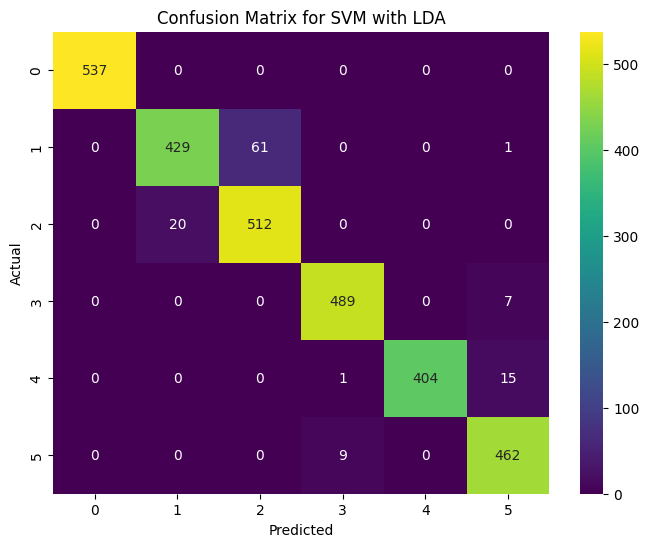


Tuning DecisionTree with LDA Model with GridSearchCV
Best Hyperparameters for DecisionTree with LDA: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Best Cross-Validation Accuracy: 95.20%

DecisionTree with LDA Performance on Test Set:
Accuracy: 95.18%
Precision: 95.37%
Recall: 95.18%
F1-Score: 95.18%

Classification Report for DecisionTree with LDA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.95      0.86      0.90       491
           2       0.88      0.96      0.92       532
           3       0.92      0.99      0.96       496
           4       1.00      0.94      0.97       420
           5       0.98      0.96      0.97       471

    accuracy                           0.95      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



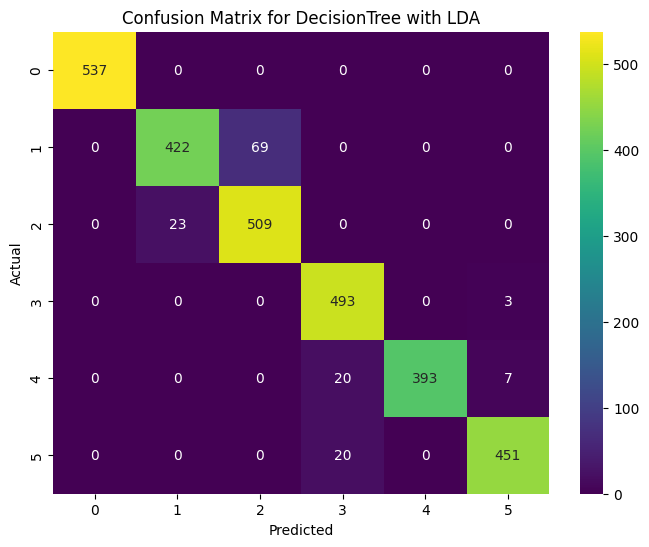


Tuning KNN with LDA Model with GridSearchCV
Best Hyperparameters for KNN with LDA: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best Cross-Validation Accuracy: 96.10%

KNN with LDA Performance on Test Set:
Accuracy: 96.64%
Precision: 96.73%
Recall: 96.64%
F1-Score: 96.63%

Classification Report for KNN with LDA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.88      0.92       491
           2       0.90      0.97      0.93       532
           3       0.98      0.99      0.99       496
           4       1.00      0.98      0.99       420
           5       0.97      0.99      0.98       471

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



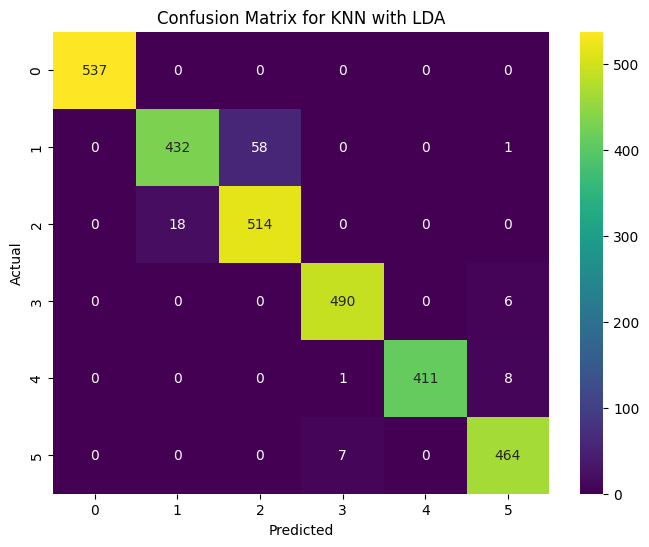


Tuning RandomForest with LDA Model with GridSearchCV
Best Hyperparameters for RandomForest with LDA: {'classifier__max_depth': 15, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Best Cross-Validation Accuracy: 95.70%

RandomForest with LDA Performance on Test Set:
Accuracy: 96.13%
Precision: 96.26%
Recall: 96.13%
F1-Score: 96.12%

Classification Report for RandomForest with LDA:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.86      0.91       491
           2       0.88      0.96      0.92       532
           3       0.96      0.99      0.98       496
           4       1.00      0.98      0.99       420
           5       0.98      0.97      0.97       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



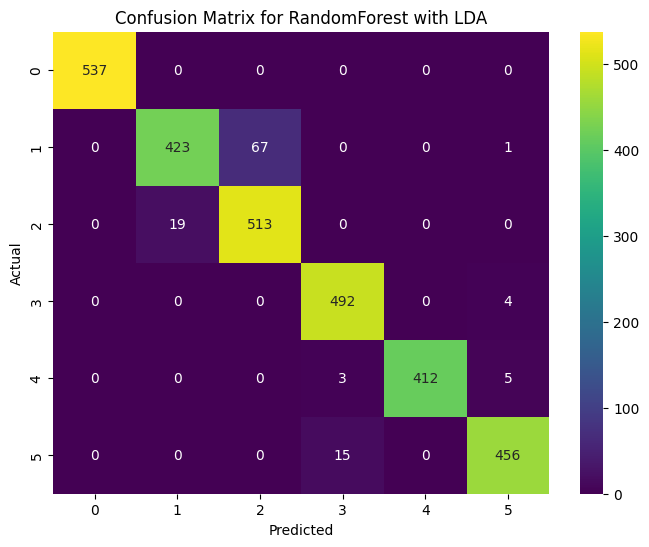

In [22]:
# Define parameter grids for each model
param_grids = {
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    'DecisionTree': {
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 10],
        'classifier__weights': ['uniform', 'distance']
    },
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
}

# Define pipelines with LDA for dimensionality reduction and the classifier
pipelines = {
    'SVM with LDA': Pipeline([
        ('dim_red', LDA(n_components=5)),
        ('classifier', SVC(random_state=random_state))
    ]),
    'DecisionTree with LDA': Pipeline([
        ('dim_red', LDA(n_components=5)),
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ]),
    'KNN with LDA': Pipeline([
        ('dim_red', LDA(n_components=5)),
        ('classifier', KNeighborsClassifier())
    ]),
    'RandomForest with LDA': Pipeline([
        ('dim_red', LDA(n_components=5)),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])
}

# Hyperparameter tuning and evaluation
for model_name, pipeline in pipelines.items():
    print(f"\nTuning {model_name} Model with GridSearchCV")

    # Extract model name and get the correct param grid
    model_key = model_name.split()[0]
    param_grid = param_grids.get(model_key)

    if param_grid is None:
        print(f"Error: No parameter grid found for {model_name}. Skipping tuning.")
        continue

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_encoded)

    # Get the best parameters and the best score
    print(f"Best Hyperparameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    # Performance metrics
    accuracy = accuracy_score(y_test_encoded, y_pred) * 100
    precision = precision_score(y_test_encoded, y_pred, average='weighted') * 100
    recall = recall_score(y_test_encoded, y_pred, average='weighted') * 100
    f1 = f1_score(y_test_encoded, y_pred, average='weighted') * 100

    print(f"\n{model_name} Performance on Test Set:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1-Score: {f1:.2f}%")
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test_encoded, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()